# Wetland water depth visualisation <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI` and `DEA Sandbox` environment 
* **Products used:** 
* **Special requirements:** 
* **Prerequisites:** This notebook assumes you have previously run the [WetlandWaterDepthAnalyses.ipynb](./WetlandWaterDepthAnalyses.ipynb) notebook and saved out a netCDF file containing all the variables at the end of the notebook.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import binned_statistic

%load_ext autoreload
%autoreload 2

## Load in our pre-analysed dataset

In [2]:
AllDataCombined = xr.open_dataset('AllDataCombined.nc')

In [3]:
AllDataCombined

<xarray.Dataset>
Dimensions:        (time: 1264, x: 483, y: 696)
Coordinates:
  * x              (x) float64 1.458e+06 1.458e+06 ... 1.47e+06 1.47e+06
  * y              (y) float64 -3.452e+06 -3.452e+06 ... -3.47e+06 -3.47e+06
  * time           (time) datetime64[ns] 1987-05-27T23:25:36.184280 ... 2019-08-15T23:49:02.469301952
Data variables:
    nbart_red      (time, y, x) float32 ...
    nbart_blue     (time, y, x) float32 ...
    nbart_green    (time, y, x) float32 ...
    nbart_nir      (time, y, x) float32 ...
    nbart_swir_1   (time, y, x) float32 ...
    nbart_swir_2   (time, y, x) float32 ...
    TCW            (time, y, x) float32 ...
    wet            (time, y, x) float32 ...
    justwetHAND    (y, x, time) float64 ...
    wetCount       (time, y, x) bool ...
    veg_randomUID  (y, x) float64 ...
    HAND           (y, x) float64 ...
    DEM            (y, x) float32 ...
    DEMCorr        (y, x) float64 ...
    DEMDir         (y, x) float64 ...
    DEMAcc         (y, x) float64 ...
Attributes:
    crs:      +proj=aea +lat_0=0 +lon_0=132 +lat_1=-18 +lat_2=-36 +x_0=0 +y_0...

We also need to load in the species dictionary we saved out

In [4]:
with open('SpeciesDict.txt', 'r') as f: 
    content = f.read()
    SpeciesDict = eval(content)

We also need to regenerate the order of vegetation communities by mean HAND, and then match up that order with the `SpeciesDict` to get the tick labels.

In [5]:
# Now recalculate our median HAND values and sort the data based on this
MedianHAND = AllDataCombined.HAND.groupby(AllDataCombined['veg_randomUID']).median()
myorder = MedianHAND.sortby(MedianHAND)['veg_randomUID'].values

In [6]:
# Grab the correct vegetation labels in the right order
XTickNames = []
for vegvalue in myorder:
    VegName = SpeciesDict[int(vegvalue)]
    XTickNames.append(VegName)

### And start playing with it

We want to map the total number of wet pixels per timestep to the vegetation categories so we can see what proportion of each vegetation category is currently 'wet'.

In [10]:
# Count the number of pixels mapped to each vegetation type
AllVegTypeCounts = pd.value_counts(AllDataCombined['veg_randomUID'].values.flatten()).to_dict()
AllVegTypeCounts = {int(key):AllVegTypeCounts[key] for key in AllVegTypeCounts}

VegNameCounts = {SpeciesDict[k]: v for k,v in AllVegTypeCounts.items()}

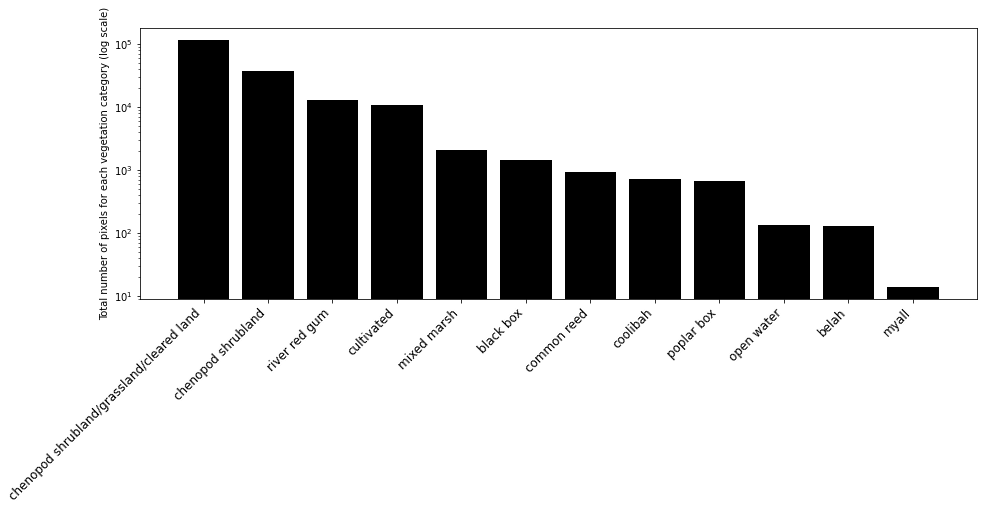

In [11]:
fig, ax = plt.subplots(figsize=[15,5])
plt.bar(VegNameCounts.keys(), VegNameCounts.values(), color = 'k')
ax.set_yscale('log')
plt.xticks(rotation=45, ha='right', fontsize=12);
plt.ylabel('Total number of pixels for each vegetation category (log scale)');

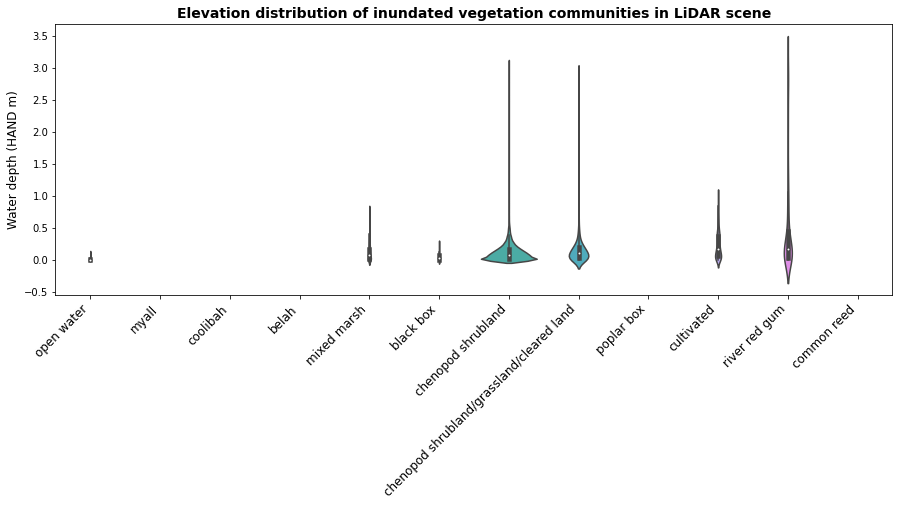

In [18]:
fig = plt.figure(figsize=[15,5])
ax = sns.violinplot(x=AllDataCombined['veg_randomUID'].values.flatten(), 
                    y=AllDataCombined['justwetHAND'].isel(time=30).values.flatten(), 
                    order=myorder, scale='count')
ax.set_xticklabels(XTickNames, rotation=45, ha='right', fontsize=12);
plt.ylabel('Water depth (HAND m)', fontsize = 12);
plt.title('Elevation distribution of inundated vegetation communities in LiDAR scene', fontsize = 14, fontweight = 'bold');

### Count the number of wet observations for each pixel, and plot against HAND

We would hope that the higher pixels are inundated less frequently...

In [19]:
AllDataCombined['WetFreq'] = AllDataCombined.wet.count(dim='time')

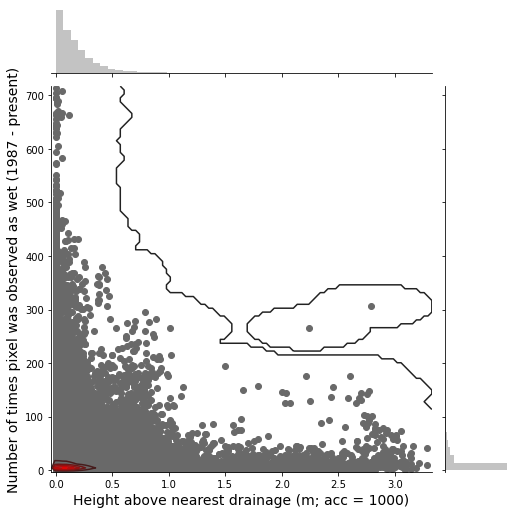

In [21]:
h = (sns.jointplot(x=AllDataCombined.HAND.values.flatten(), 
                   y=AllDataCombined.WetFreq.values.flatten(), 
                   kind='scatter', height=7,color='dimgrey').plot_joint(sns.kdeplot, 
                                                         zorder=1,
                                                         n_levels=5, color='r'));
h.set_axis_labels(f'Height above nearest drainage (m; acc = 1000)', 
                  'Number of times pixel was observed as wet (1987 - present)', fontsize=14);

## Calculate wet count per scene curves

In [482]:
WetCountPerTime = AllDataCombined.wetCount.sum(dim=['x', 'y'])
WetCountPerTime = WetCountPerTime[WetCountPerTime != 0]
count, bin_edges, binnumber = binned_statistic(WetCountPerTime, WetCountPerTime, bins=100, statistic='count')
countpct = (count/count.sum()) * 100

In [479]:
BinnedWetCounts = pd.DataFrame(zip(bin_edges[1:-1],countpct[1:]), columns=['bins','countpct'])

In [530]:
SortedWetCounts = pd.DataFrame(zip(-np.sort(-WetCountPerTime.values),pct), columns=['wetcount','obsnumber'])

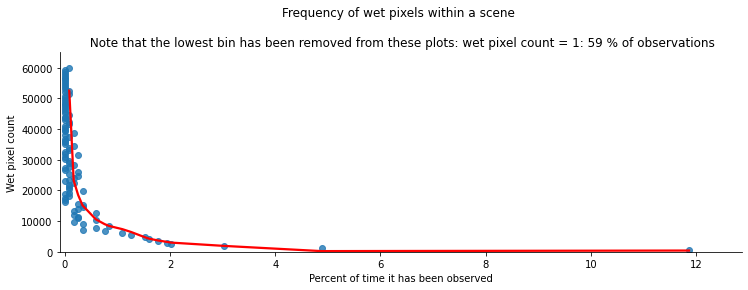

In [496]:
h = sns.lmplot('countpct', 'bins', BinnedWetCounts, lowess=True, 
               height=3.5, aspect=3, line_kws={'color':'r'});
h.set(ylim=(0, 65000));
h.set(xlim=(-0.1, BinnedWetCounts.countpct.max() + 1));
h.set(ylabel='Wet pixel count', 
      xlabel='Percent of time it has been observed',
      title=f'Frequency of wet pixels within a scene \n\n Note that the lowest bin has been removed from these plots: wet pixel count = {int(bin_edges[0])}: {int(countpct[0])} % of observations');

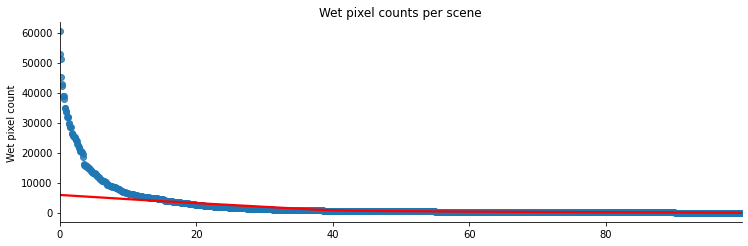

In [531]:
h = sns.lmplot('obsnumber', 'wetcount', SortedWetCounts, lowess=True, 
               height=3.5, aspect=3, line_kws={'color':'r'});
h.set(xlabel='', 
      ylabel='Wet pixel count',
      title=f'Wet pixel counts per scene');

In [506]:
len(-np.sort(-WetCountPerTime.values))

1188

In [528]:
pct = (SortedWetCounts.obsnumber.values) / len(-np.sort(-WetCountPerTime.values)) * 100

In [520]:
range(len(WetCountPerTime.values))

range(0, 1188)

In [529]:
pct

array([0.00000000e+00, 8.41750842e-02, 1.68350168e-01, ...,
       9.97474747e+01, 9.98316498e+01, 9.99158249e+01])